In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

Load dataset

In [2]:
data = pd.read_csv("synthetic_spam_dataset.csv")

In [3]:
print(data.head())

   word_freq_free  word_freq_money  word_freq_offer  email_length  spam
0            1.87             4.04             4.70           227     1
1            4.75             4.48             4.77           212     1
2            3.66             1.59             4.57           429     1
3            2.99             0.55             1.85            82     1
4            0.78             1.14             0.08           466     0


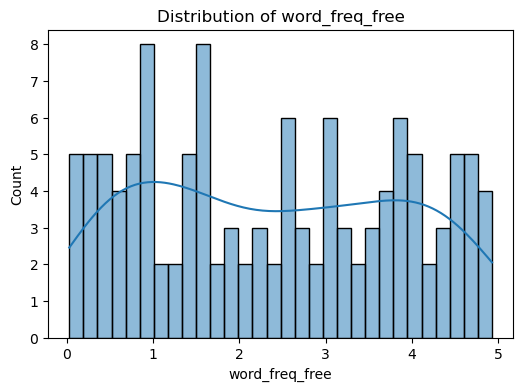

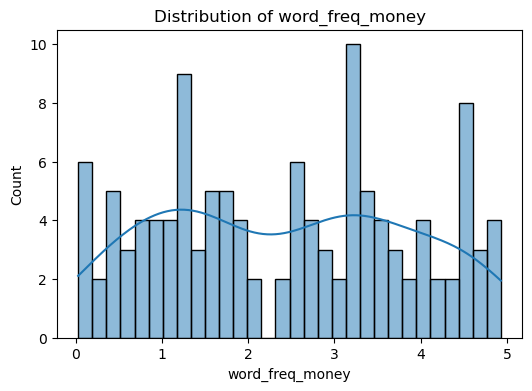

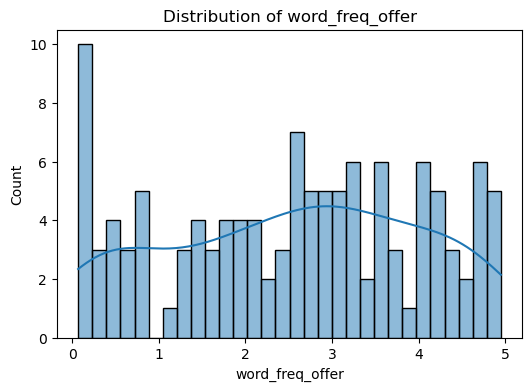

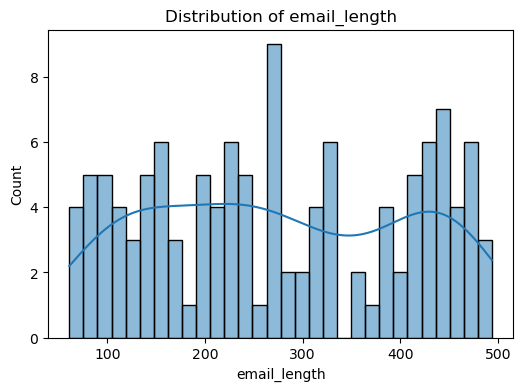

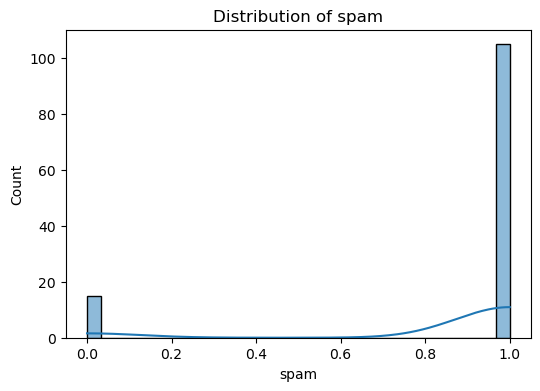

In [4]:
for col in data.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


Data Cleaning

In [5]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 word_freq_free     0
word_freq_money    0
word_freq_offer    0
email_length       0
spam               0
dtype: int64


In [6]:
print("Duplicates:", data.duplicated().sum())

Duplicates: 0


In [7]:
print("Data types:\n", data.dtypes)

Data types:
 word_freq_free     float64
word_freq_money    float64
word_freq_offer    float64
email_length         int64
spam                 int64
dtype: object


In [8]:
print("\nData Summary:\n", data.describe())


Data Summary:
        word_freq_free  word_freq_money  word_freq_offer  email_length  \
count      120.000000       120.000000       120.000000    120.000000   
mean         2.385417         2.417667         2.548750    275.916667   
std          1.489314         1.437215         1.459425    131.331807   
min          0.030000         0.030000         0.070000     61.000000   
25%          0.987500         1.197500         1.422500    153.000000   
50%          2.415000         2.510000         2.680000    266.000000   
75%          3.785000         3.530000         3.692500    411.500000   
max          4.930000         4.930000         4.950000    494.000000   

             spam  
count  120.000000  
mean     0.875000  
std      0.332106  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  


In [9]:
for col in ['word_freq_free', 'word_freq_money', 'word_freq_offer', 'email_length']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((data[col] < lower) | (data[col] > upper)).sum()
    print(f"{col}: {outliers} outliers")

word_freq_free: 0 outliers
word_freq_money: 0 outliers
word_freq_offer: 0 outliers
email_length: 0 outliers


In [10]:
X = data[['word_freq_free', 'word_freq_money', 'word_freq_offer', 'email_length']]
y = data['spam']

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.1, 0.01]   # only for rbf
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [13]:
cv_acc = cross_val_score(best_model, X, y, cv=5, scoring='accuracy').mean()
cv_auc = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc').mean()

In [14]:
print("Best Params:", grid.best_params_)
print("CV Accuracy:", cv_acc)
print("CV ROC-AUC:", cv_auc)

Best Params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
CV Accuracy: 0.9166666666666666
CV ROC-AUC: 0.9301587301587302


In [15]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [16]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Test Accuracy: 0.9583333333333334
Test ROC-AUC: 1.0


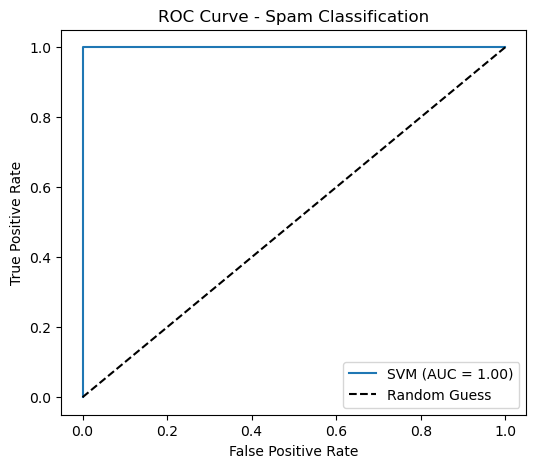

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Spam Classification")
plt.legend()
plt.show()

In [21]:
new_email = [[2.1, 1.3, 0.7, 180]]
prediction = best_model.predict(new_email)
prob = best_model.predict_proba(new_email)[0, 1]

print(f"New Email Prediction: {'Spam' if prediction[0]==1 else 'Not Spam'} (Prob={prob:.2f})")

New Email Prediction: Not Spam (Prob=0.52)


c:\Users\HP\anaconda3\anaconda34\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\anaconda3\anaconda34\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
import pickle

svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

svm_pipeline.fit(X, y)

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_pipeline, f)

print("✅ Model (with scaler) saved as svm_model.pkl")

✅ Model (with scaler) saved as svm_model.pkl
